# 데모

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [4]:
data_dir = Path('../data/dacon-dku')
feature_dir = Path('../build/feature')
val_dir = Path('../build/val')
tst_dir = Path('../build/tst')
sub_dir = Path('../build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [5]:
algo_name = 'lgb_hyperopt'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,-15.0556
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,-0.3069
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,-0.9014
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,-1.3906
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,-9.3609


In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


## Hyperparameter Tuning

In [8]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [9]:
params = {
    "objective": "multiclass",
    "n_estimators": 1000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "num_leaves": hp.choice("num_leaves", [15, 31, 63, 127]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, .9, 0.1),
    "subsample": hp.quniform("subsample", .5, .9, 0.1),
    "min_child_samples": hp.choice('min_child_samples', [10, 25, 100])
}

In [10]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|██████████| 10/10 [02:45<00:00, 16.55s/trial, best loss: 0.161683208975629] 
{'objective': 'multiclass', 'n_estimators': 1000, 'subsample_freq': 1, 'random_state': 42, 'n_jobs': -1, 'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.03108434204266342, 'min_child_samples': 10, 'num_leaves': 127, 'subsample': 0.6000000000000001}


## Stratified K-Fold Cross Validation

In [11]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

In [12]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.954233
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.924743
[3]	valid_0's multi_logloss: 0.894827
[4]	valid_0's multi_logloss: 0.866741
[5]	valid_0's multi_logloss: 0.839951
[6]	valid_0's multi_logloss: 0.816908
[7]	valid_0's multi_logloss: 0.793714
[8]	valid_0's multi_logloss: 0.772796
[9]	valid_0's multi_logloss: 0.753847
[10]	valid_0's multi_logloss: 0.73288
[11]	valid_0's multi_logloss: 0.71286
[12]	valid_0's multi_logloss: 0.693807
[13]	valid_0's multi_logloss: 0.675524
[14]	valid_0's multi_logloss: 0.65779
[15]	valid_0's multi_logloss: 0.641412
[16]	valid_0's multi_logloss: 0.626447
[17]	valid_0's multi_logloss: 0.611459
[18]	valid_0's multi_logloss: 0.596917
[19]	valid_0's multi_logloss: 0.583272
[20]	valid_0's multi_logloss: 0.570976
[21]	valid_0's multi_logloss: 0.557878
[22]	valid_0's multi_logloss: 0.545354
[23]	valid_0's multi_logloss: 0.533336
[24]	valid_0's multi_logloss:

[208]	valid_0's multi_logloss: 0.16824
[209]	valid_0's multi_logloss: 0.16811
[210]	valid_0's multi_logloss: 0.167952
[211]	valid_0's multi_logloss: 0.167869
[212]	valid_0's multi_logloss: 0.167742
[213]	valid_0's multi_logloss: 0.167655
[214]	valid_0's multi_logloss: 0.167534
[215]	valid_0's multi_logloss: 0.167433
[216]	valid_0's multi_logloss: 0.16729
[217]	valid_0's multi_logloss: 0.167203
[218]	valid_0's multi_logloss: 0.167126
[219]	valid_0's multi_logloss: 0.167008
[220]	valid_0's multi_logloss: 0.166889
[221]	valid_0's multi_logloss: 0.166763
[222]	valid_0's multi_logloss: 0.166685
[223]	valid_0's multi_logloss: 0.166572
[224]	valid_0's multi_logloss: 0.166463
[225]	valid_0's multi_logloss: 0.166375
[226]	valid_0's multi_logloss: 0.166283
[227]	valid_0's multi_logloss: 0.166225
[228]	valid_0's multi_logloss: 0.166126
[229]	valid_0's multi_logloss: 0.16602
[230]	valid_0's multi_logloss: 0.165921
[231]	valid_0's multi_logloss: 0.165828
[232]	valid_0's multi_logloss: 0.165753
[233

[416]	valid_0's multi_logloss: 0.160129
[417]	valid_0's multi_logloss: 0.160125
[418]	valid_0's multi_logloss: 0.160121
[419]	valid_0's multi_logloss: 0.160103
[420]	valid_0's multi_logloss: 0.160108
[421]	valid_0's multi_logloss: 0.160092
[422]	valid_0's multi_logloss: 0.160078
[423]	valid_0's multi_logloss: 0.160082
[424]	valid_0's multi_logloss: 0.160064
[425]	valid_0's multi_logloss: 0.160055
[426]	valid_0's multi_logloss: 0.160047
[427]	valid_0's multi_logloss: 0.160034
[428]	valid_0's multi_logloss: 0.160026
[429]	valid_0's multi_logloss: 0.160011
[430]	valid_0's multi_logloss: 0.160007
[431]	valid_0's multi_logloss: 0.159993
[432]	valid_0's multi_logloss: 0.159981
[433]	valid_0's multi_logloss: 0.159985
[434]	valid_0's multi_logloss: 0.159976
[435]	valid_0's multi_logloss: 0.159972
[436]	valid_0's multi_logloss: 0.159973
[437]	valid_0's multi_logloss: 0.159971
[438]	valid_0's multi_logloss: 0.159968
[439]	valid_0's multi_logloss: 0.159958
[440]	valid_0's multi_logloss: 0.159958


[100]	valid_0's multi_logloss: 0.217185
[101]	valid_0's multi_logloss: 0.216009
[102]	valid_0's multi_logloss: 0.214882
[103]	valid_0's multi_logloss: 0.213669
[104]	valid_0's multi_logloss: 0.212603
[105]	valid_0's multi_logloss: 0.211497
[106]	valid_0's multi_logloss: 0.210492
[107]	valid_0's multi_logloss: 0.20973
[108]	valid_0's multi_logloss: 0.20862
[109]	valid_0's multi_logloss: 0.207614
[110]	valid_0's multi_logloss: 0.20681
[111]	valid_0's multi_logloss: 0.206026
[112]	valid_0's multi_logloss: 0.205273
[113]	valid_0's multi_logloss: 0.204342
[114]	valid_0's multi_logloss: 0.203568
[115]	valid_0's multi_logloss: 0.202677
[116]	valid_0's multi_logloss: 0.201786
[117]	valid_0's multi_logloss: 0.200867
[118]	valid_0's multi_logloss: 0.20015
[119]	valid_0's multi_logloss: 0.199589
[120]	valid_0's multi_logloss: 0.19875
[121]	valid_0's multi_logloss: 0.198134
[122]	valid_0's multi_logloss: 0.197505
[123]	valid_0's multi_logloss: 0.196762
[124]	valid_0's multi_logloss: 0.196116
[125]

[307]	valid_0's multi_logloss: 0.162328
[308]	valid_0's multi_logloss: 0.162319
[309]	valid_0's multi_logloss: 0.162296
[310]	valid_0's multi_logloss: 0.162281
[311]	valid_0's multi_logloss: 0.162268
[312]	valid_0's multi_logloss: 0.162227
[313]	valid_0's multi_logloss: 0.162214
[314]	valid_0's multi_logloss: 0.162189
[315]	valid_0's multi_logloss: 0.162166
[316]	valid_0's multi_logloss: 0.162155
[317]	valid_0's multi_logloss: 0.162107
[318]	valid_0's multi_logloss: 0.162083
[319]	valid_0's multi_logloss: 0.162069
[320]	valid_0's multi_logloss: 0.162042
[321]	valid_0's multi_logloss: 0.162009
[322]	valid_0's multi_logloss: 0.161975
[323]	valid_0's multi_logloss: 0.161956
[324]	valid_0's multi_logloss: 0.161931
[325]	valid_0's multi_logloss: 0.161894
[326]	valid_0's multi_logloss: 0.161864
[327]	valid_0's multi_logloss: 0.161847
[328]	valid_0's multi_logloss: 0.161812
[329]	valid_0's multi_logloss: 0.161788
[330]	valid_0's multi_logloss: 0.161774
[331]	valid_0's multi_logloss: 0.16177
[

[11]	valid_0's multi_logloss: 0.713619
[12]	valid_0's multi_logloss: 0.694688
[13]	valid_0's multi_logloss: 0.676479
[14]	valid_0's multi_logloss: 0.658913
[15]	valid_0's multi_logloss: 0.642531
[16]	valid_0's multi_logloss: 0.62773
[17]	valid_0's multi_logloss: 0.612756
[18]	valid_0's multi_logloss: 0.598165
[19]	valid_0's multi_logloss: 0.584509
[20]	valid_0's multi_logloss: 0.572201
[21]	valid_0's multi_logloss: 0.559133
[22]	valid_0's multi_logloss: 0.546609
[23]	valid_0's multi_logloss: 0.534654
[24]	valid_0's multi_logloss: 0.524197
[25]	valid_0's multi_logloss: 0.513213
[26]	valid_0's multi_logloss: 0.50426
[27]	valid_0's multi_logloss: 0.494082
[28]	valid_0's multi_logloss: 0.484001
[29]	valid_0's multi_logloss: 0.475354
[30]	valid_0's multi_logloss: 0.466321
[31]	valid_0's multi_logloss: 0.458531
[32]	valid_0's multi_logloss: 0.450162
[33]	valid_0's multi_logloss: 0.441482
[34]	valid_0's multi_logloss: 0.433139
[35]	valid_0's multi_logloss: 0.425244
[36]	valid_0's multi_loglos

[221]	valid_0's multi_logloss: 0.168143
[222]	valid_0's multi_logloss: 0.168068
[223]	valid_0's multi_logloss: 0.167962
[224]	valid_0's multi_logloss: 0.167856
[225]	valid_0's multi_logloss: 0.16775
[226]	valid_0's multi_logloss: 0.167649
[227]	valid_0's multi_logloss: 0.167568
[228]	valid_0's multi_logloss: 0.16746
[229]	valid_0's multi_logloss: 0.167354
[230]	valid_0's multi_logloss: 0.167221
[231]	valid_0's multi_logloss: 0.167103
[232]	valid_0's multi_logloss: 0.167009
[233]	valid_0's multi_logloss: 0.166936
[234]	valid_0's multi_logloss: 0.166853
[235]	valid_0's multi_logloss: 0.166757
[236]	valid_0's multi_logloss: 0.16668
[237]	valid_0's multi_logloss: 0.166582
[238]	valid_0's multi_logloss: 0.166519
[239]	valid_0's multi_logloss: 0.166405
[240]	valid_0's multi_logloss: 0.166328
[241]	valid_0's multi_logloss: 0.166262
[242]	valid_0's multi_logloss: 0.166205
[243]	valid_0's multi_logloss: 0.16613
[244]	valid_0's multi_logloss: 0.166036
[245]	valid_0's multi_logloss: 0.16601
[246]

[429]	valid_0's multi_logloss: 0.161292
[430]	valid_0's multi_logloss: 0.161291
[431]	valid_0's multi_logloss: 0.161286
[432]	valid_0's multi_logloss: 0.161284
[433]	valid_0's multi_logloss: 0.161276
[434]	valid_0's multi_logloss: 0.161277
[435]	valid_0's multi_logloss: 0.161273
[436]	valid_0's multi_logloss: 0.161267
[437]	valid_0's multi_logloss: 0.161261
[438]	valid_0's multi_logloss: 0.161254
[439]	valid_0's multi_logloss: 0.161231
[440]	valid_0's multi_logloss: 0.161227
[441]	valid_0's multi_logloss: 0.16123
[442]	valid_0's multi_logloss: 0.161226
[443]	valid_0's multi_logloss: 0.161208
[444]	valid_0's multi_logloss: 0.161189
[445]	valid_0's multi_logloss: 0.16119
[446]	valid_0's multi_logloss: 0.161184
[447]	valid_0's multi_logloss: 0.161173
[448]	valid_0's multi_logloss: 0.161175
[449]	valid_0's multi_logloss: 0.161161
[450]	valid_0's multi_logloss: 0.161157
[451]	valid_0's multi_logloss: 0.161163
[452]	valid_0's multi_logloss: 0.161166
[453]	valid_0's multi_logloss: 0.16116
[45

[177]	valid_0's multi_logloss: 0.175458
[178]	valid_0's multi_logloss: 0.175235
[179]	valid_0's multi_logloss: 0.175049
[180]	valid_0's multi_logloss: 0.174812
[181]	valid_0's multi_logloss: 0.174595
[182]	valid_0's multi_logloss: 0.174374
[183]	valid_0's multi_logloss: 0.174125
[184]	valid_0's multi_logloss: 0.173943
[185]	valid_0's multi_logloss: 0.173739
[186]	valid_0's multi_logloss: 0.173502
[187]	valid_0's multi_logloss: 0.173329
[188]	valid_0's multi_logloss: 0.173135
[189]	valid_0's multi_logloss: 0.172902
[190]	valid_0's multi_logloss: 0.172691
[191]	valid_0's multi_logloss: 0.172475
[192]	valid_0's multi_logloss: 0.17233
[193]	valid_0's multi_logloss: 0.172178
[194]	valid_0's multi_logloss: 0.172011
[195]	valid_0's multi_logloss: 0.171808
[196]	valid_0's multi_logloss: 0.171647
[197]	valid_0's multi_logloss: 0.171438
[198]	valid_0's multi_logloss: 0.171258
[199]	valid_0's multi_logloss: 0.171101
[200]	valid_0's multi_logloss: 0.170928
[201]	valid_0's multi_logloss: 0.170762
[

[384]	valid_0's multi_logloss: 0.161985
[385]	valid_0's multi_logloss: 0.161977
[386]	valid_0's multi_logloss: 0.16196
[387]	valid_0's multi_logloss: 0.161939
[388]	valid_0's multi_logloss: 0.161936
[389]	valid_0's multi_logloss: 0.161934
[390]	valid_0's multi_logloss: 0.161913
[391]	valid_0's multi_logloss: 0.161886
[392]	valid_0's multi_logloss: 0.161877
[393]	valid_0's multi_logloss: 0.161868
[394]	valid_0's multi_logloss: 0.161859
[395]	valid_0's multi_logloss: 0.161858
[396]	valid_0's multi_logloss: 0.16185
[397]	valid_0's multi_logloss: 0.161822
[398]	valid_0's multi_logloss: 0.161816
[399]	valid_0's multi_logloss: 0.161809
[400]	valid_0's multi_logloss: 0.161807
[401]	valid_0's multi_logloss: 0.161796
[402]	valid_0's multi_logloss: 0.16179
[403]	valid_0's multi_logloss: 0.161779
[404]	valid_0's multi_logloss: 0.161777
[405]	valid_0's multi_logloss: 0.161775
[406]	valid_0's multi_logloss: 0.161752
[407]	valid_0's multi_logloss: 0.161756
[408]	valid_0's multi_logloss: 0.16175
[409

[31]	valid_0's multi_logloss: 0.457829
[32]	valid_0's multi_logloss: 0.449476
[33]	valid_0's multi_logloss: 0.440822
[34]	valid_0's multi_logloss: 0.432529
[35]	valid_0's multi_logloss: 0.424637
[36]	valid_0's multi_logloss: 0.417437
[37]	valid_0's multi_logloss: 0.410601
[38]	valid_0's multi_logloss: 0.403977
[39]	valid_0's multi_logloss: 0.39755
[40]	valid_0's multi_logloss: 0.39134
[41]	valid_0's multi_logloss: 0.385308
[42]	valid_0's multi_logloss: 0.379451
[43]	valid_0's multi_logloss: 0.373503
[44]	valid_0's multi_logloss: 0.368619
[45]	valid_0's multi_logloss: 0.363466
[46]	valid_0's multi_logloss: 0.358546
[47]	valid_0's multi_logloss: 0.353759
[48]	valid_0's multi_logloss: 0.348934
[49]	valid_0's multi_logloss: 0.343782
[50]	valid_0's multi_logloss: 0.339517
[51]	valid_0's multi_logloss: 0.334837
[52]	valid_0's multi_logloss: 0.330646
[53]	valid_0's multi_logloss: 0.326413
[54]	valid_0's multi_logloss: 0.322597
[55]	valid_0's multi_logloss: 0.318762
[56]	valid_0's multi_loglos

[241]	valid_0's multi_logloss: 0.165649
[242]	valid_0's multi_logloss: 0.165553
[243]	valid_0's multi_logloss: 0.165464
[244]	valid_0's multi_logloss: 0.165388
[245]	valid_0's multi_logloss: 0.16534
[246]	valid_0's multi_logloss: 0.165284
[247]	valid_0's multi_logloss: 0.165237
[248]	valid_0's multi_logloss: 0.165155
[249]	valid_0's multi_logloss: 0.165089
[250]	valid_0's multi_logloss: 0.165023
[251]	valid_0's multi_logloss: 0.164961
[252]	valid_0's multi_logloss: 0.164895
[253]	valid_0's multi_logloss: 0.164837
[254]	valid_0's multi_logloss: 0.164778
[255]	valid_0's multi_logloss: 0.164718
[256]	valid_0's multi_logloss: 0.164671
[257]	valid_0's multi_logloss: 0.164604
[258]	valid_0's multi_logloss: 0.164531
[259]	valid_0's multi_logloss: 0.164479
[260]	valid_0's multi_logloss: 0.164416
[261]	valid_0's multi_logloss: 0.164344
[262]	valid_0's multi_logloss: 0.164282
[263]	valid_0's multi_logloss: 0.164202
[264]	valid_0's multi_logloss: 0.164151
[265]	valid_0's multi_logloss: 0.164094
[

[451]	valid_0's multi_logloss: 0.160277
[452]	valid_0's multi_logloss: 0.160281
[453]	valid_0's multi_logloss: 0.160273
[454]	valid_0's multi_logloss: 0.160278
[455]	valid_0's multi_logloss: 0.160277
[456]	valid_0's multi_logloss: 0.160276
[457]	valid_0's multi_logloss: 0.160282
[458]	valid_0's multi_logloss: 0.160276
[459]	valid_0's multi_logloss: 0.160272
[460]	valid_0's multi_logloss: 0.16027
[461]	valid_0's multi_logloss: 0.160266
[462]	valid_0's multi_logloss: 0.160265
[463]	valid_0's multi_logloss: 0.160254
[464]	valid_0's multi_logloss: 0.160247
[465]	valid_0's multi_logloss: 0.160237
[466]	valid_0's multi_logloss: 0.160213
[467]	valid_0's multi_logloss: 0.160199
[468]	valid_0's multi_logloss: 0.160192
[469]	valid_0's multi_logloss: 0.160181
[470]	valid_0's multi_logloss: 0.160176
[471]	valid_0's multi_logloss: 0.160172
[472]	valid_0's multi_logloss: 0.160152
[473]	valid_0's multi_logloss: 0.160157
[474]	valid_0's multi_logloss: 0.160163
[475]	valid_0's multi_logloss: 0.160149
[

In [13]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.2728%


In [14]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [15]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

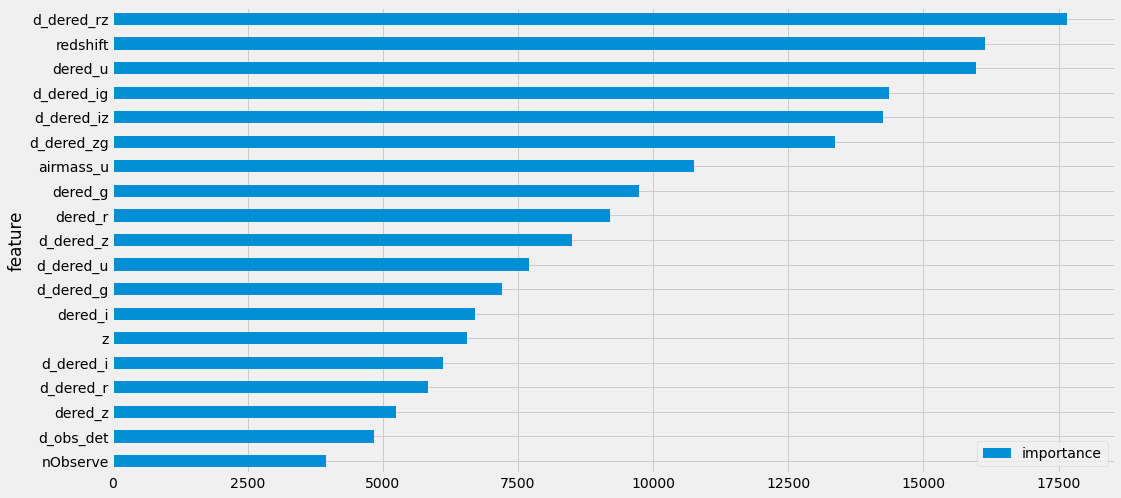

In [16]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [17]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [18]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [19]:
sub[target_col].value_counts()

2    41076
0    29965
1     8959
Name: class, dtype: int64

In [20]:
sub.to_csv(sub_file)